In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from math import pi as pi
import re

In [2]:
def get_file(filename):
    line=[]
    # TODO: magic number 
    length=2105601
    with open(filename, "r") as file:
        for i in range(0,length):
            line.append(file.readline())
    return line  

def intfromstr(string1):
    return int(re.search(r'\d+', string1).group())

In [3]:
class SansData:
    def __init__(self, filename, title=None, textsize=12):
        # Initialization with detector settings and file loading
        self.filename = filename
        self.setup_detector_geometry()
        self.load_data(filename)
        self.process_data()
        self.velocity_selector_speed = self.load_velocity_selector()
        self.lam = self.calculate_lambda_from_velocity(self.velocity_selector_speed)  # Calculate lambda from velocity
        print(f"lamda: {self.lam}")

        # Define the ranges and beam stop information here
        self.x_ranges = [(400, 450), (450, 600)]
        self.y_ranges = [(200, 250), (250, 300)]
        self.beam_stop_range_x = (430, 480)
        self.beam_stop_range_y = (230, 260)
        
        # Initialize the attributes with default values
        self.delta_omega = 1.0  # Example value
        self.d_sample = 0.05     # Example value
        self.i0_lambda = 1.0    # Example value
        self.transmission_lambda = 1.0  # Example value
        # Define the distances based on the provided geometry (in mm)
        self.distances = {
            'D_to_DS': 1320 + 0,        # Distance from diaphragm to sample, + PosFzz
            'DS_to_S': 1320,     # Distance from DS to Sample
            'DS_to_KB3': 2802,    # Distance from Sample to KB3
            'DS_to_KB2': 4793,  # Distance from KB3 to KB2
            'DS_to_KB1': 8798,  # Distance from KB2 to KB1
            'DS_to_PB1': 11606  # Distance from KB1 to P01
        }
        # Define the apertures sizes (in mm) for each diaphragm
        self.apertures = {
            'D': 10,       # Aperture size for diaphragm D
            'DS': 10,      # Aperture size for DS
            'S': 10,       # Aperture size for Sample
            'KB3': 10,     # Aperture size for KB3
            'KB2': 10,     # Aperture size for KB2
            'KB1': 10,     # Aperture size for KB1
            'PB1': 10      # Aperture size for P01
        }

    def load_data(self, filename):
        # Assuming get_file, integerisation, and intfromstr are defined
        data = get_file(filename)
        offset = 29
        self.filename = filename
        self.sample = data[1]
        self.runtime = intfromstr(data[46])

        # TODO: decode magic numbers and meaning of offset
        cdat2 = np.array(data[6398 + offset:1054974 + offset]).astype(int)
        self.cdat2_2d = np.reshape(cdat2, (1024, 1024))

        self.twod= np.transpose(self.cdat2_2d[self.xmin:self.xmax, self.ymin:self.ymax])
        # Center the twod data
        # Print the arrays and their shapes
        print(f"self.cdat2_2d shape: {self.cdat2_2d.shape}")
        print(f"self.twod shape: {self.twod.shape}")

    def process_data(self):
        self.i_s = np.sum(self.twod, axis=0) 
        # Any additional data processing
        pass
    
    def setup_detector_geometry(self):
        # Detector geometry setup
        self.ymin = 50
        self.ymax = 1024 - 50
        self.y = (1024-100)
        self.pixely = 0.5 / self.y #ypixel size [m]
        self.xmin = 275 
        self.xmax = 750
        self.x = 1024 - 275 - 274 #number of x pixels #changed from 225 to 275
        self.pixelx = 0.5 / self.x #xpixel size [m]
        self.d = (self.load_distance() +1320)/1000 # [m] 1320 is the offset
        self.n_sectors = 6
        #Sample to detector distance is FZZ +1320
        print(f"Pixel size X: {self.pixelx} m, Pixel size Y: {self.pixely} m")
    
    def load_val_from_line(self, n):
        with open(self.filename, 'r') as file:
            lines = file.readlines()
            assert(len(lines) >= n+1)
            line = lines[n].strip()
            # Assuming the distance is always 2.520 as per your requirement
            distance = float(line.split('=')[1])
            return distance

    def load_distance(self):
        return self.load_val_from_line(6)
    
    def load_velocity_selector(self):
        return self.load_val_from_line(17)
        
    def calculate_lambda_from_velocity(self, velocity):
        rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100]) # from the test data
        wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])
        sorted_indices = np.argsort(rpm)
        sorted_wavelengths = wavelengths[sorted_indices]
        sorted_rpm = rpm[sorted_indices]
        
        # Fits the mapping from RPM to wavelength
        def fit_func(x, a, b):
            return a / x + b
        
        # Perform linear fit
        popt, _ = curve_fit(fit_func, sorted_rpm, sorted_wavelengths)
        interpolated_lambda = fit_func(velocity, *popt)
        print(f"Interpolated lambda: {interpolated_lambda} Å for velocity {velocity} RPM")
        return interpolated_lambda
    
    def plot_integrated_intensity(self, data=None, axis=0, title='Integrated Intensity', filename=None):
        """
        Plot combined integrated intensities along both X and Y axes with both pixel and distance representations.
        """
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Arrange plots in 2 rows, 1 column

        # Plot integrated intensity along X-axis (summed over Y) in pixels
        data = self.twod
        integrated_intensity_x = np.sum(data, axis=0)
        integrated_intensity_y = np.sum(data, axis=1)

        ax = axes[0]
        x_values_pixels = np.arange(integrated_intensity_x.size)
        ax.plot(x_values_pixels, integrated_intensity_x)

        # ax.set_xlim(200, 300)
        ax.set_title('Integrated Intensity over X-axis (Summed over Y)')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        # Plot integrated intensity along Y-axis (summed over X) in pixels
        ax = axes[1]
        y_values_pixels = np.arange(integrated_intensity_y.size)
        ax.plot(y_values_pixels, integrated_intensity_y)

        ax.set_xlim(300, 600)
        ax.set_title('Integrated Intensity over Y-axis (Summed over X)')
        ax.set_xlabel('Y (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        plt.tight_layout()
        plt.show()
            
    def plot_2d(self):
        """
        Plot the 2D intensity data.
        """
        norm = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.show()
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.xlim(200, 300)
        plt.ylim(350, 600)
        plt.show()
        

Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
self.cdat2_2d shape: (1024, 1024)
self.twod shape: (924, 475)
Interpolated lambda: 5.997383326898995 Å for velocity 21202.0 RPM
lamda: 5.997383326898995


/tmp/ipykernel_86790/202969486.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_86790/202969486.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


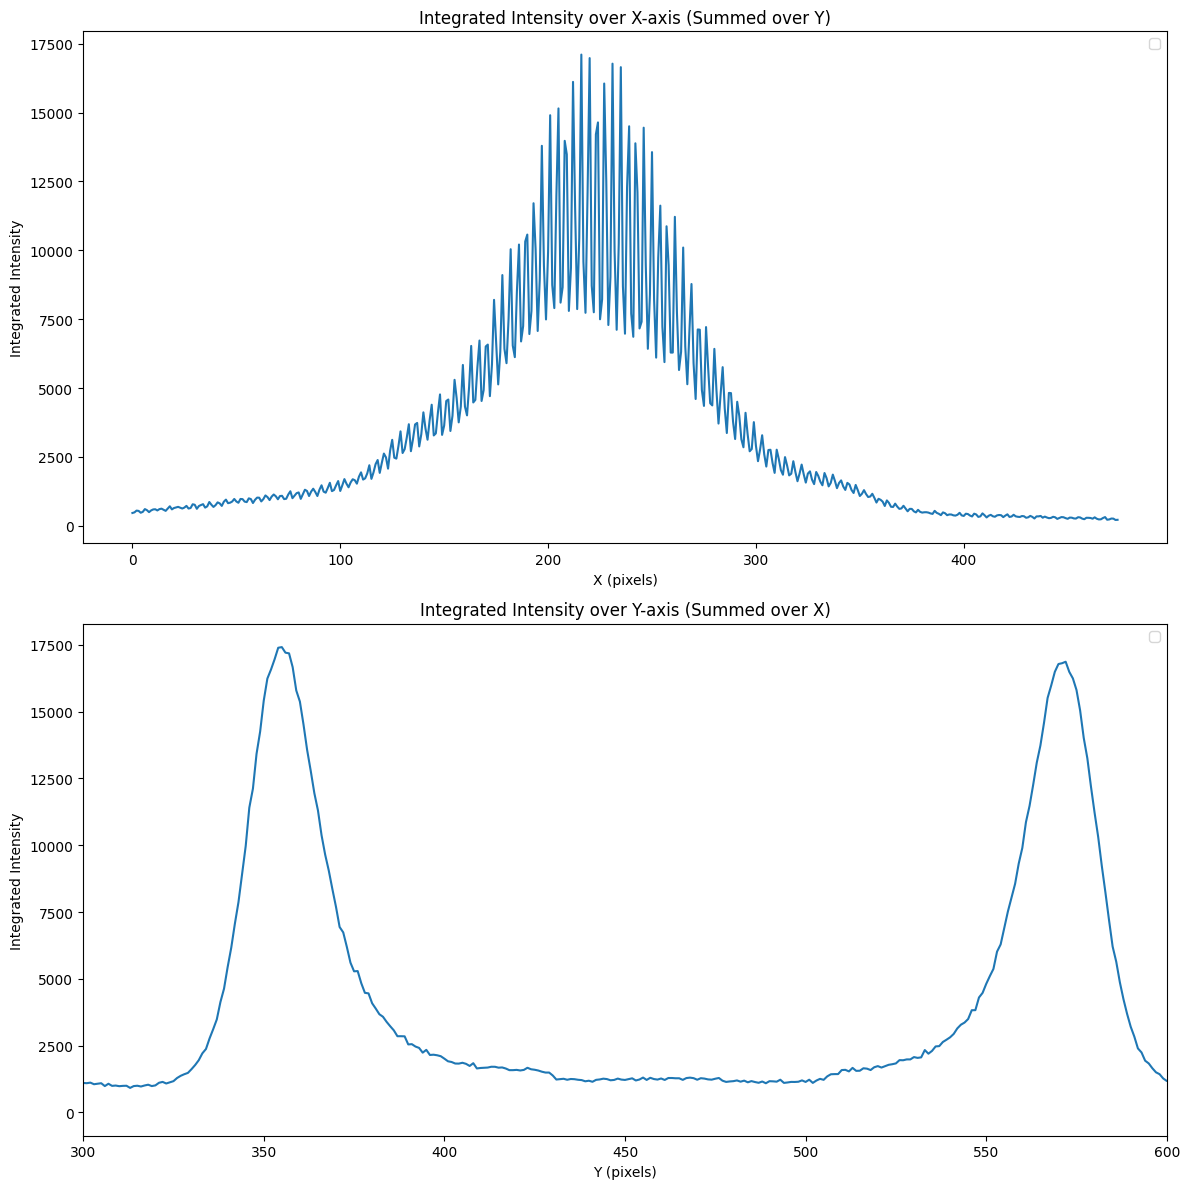

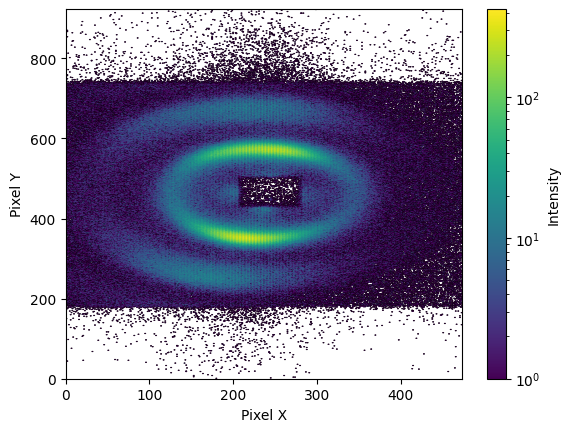

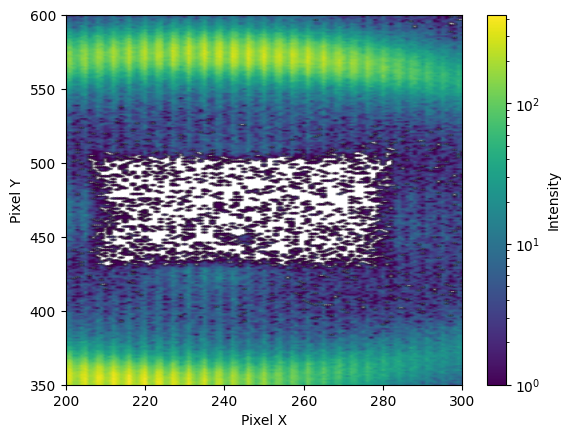

In [4]:
glassyC_sample = SansData('data/memb_BS_Q1_6_0Ang.mpa')
glassyC_sample.plot_integrated_intensity(axis=0, title='Integrated Intensity over X-axis')
glassyC_sample.plot_2d()